In [213]:
import numpy as np
import astropy.units as au
import astropy.constants as ac
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

def mask_hdu(hdu, l, b, r):
    """
    Function to mask a FITS HDU given a position (l, b) and radius (r).
    
    Inputs:
    - hdu: FITS HDU object
    - l, b: Galactic coordinates in degrees for the center of the mask.
    - r: Radius in arcseconds for the mask.

    Outputs:
    - Masked FITS HDU object
    """
    wcs = WCS(hdu.header)

    center = SkyCoord(l, b, frame='galactic', unit='deg')
    radius = u.Quantity(r, unit='arcsec')

    # Define the mask region
    mask_region = CircleSkyRegion(center, radius)

    # Convert the sky region to pixel region
    mask_region_pix = mask_region.to_pixel(wcs)

    # Create a 2D mask array with the same shape as the data
    y, x = hdu.data.shape
    mask = mask_region_pix.to_mask().to_image(shape=(y, x))
    
    # Apply the mask to the data by setting masked pixels to a desired value, e.g., NaN
    hdu_masked = hdu.copy()
    hdu_masked.data[mask==0] = np.nan
    
    cutout = Cutout2D(hdu_masked.data, center, radius*2, wcs=wcs)  # Create a square cutout
    hdu_masked.data = cutout.data  # Update the data in the cropped HDU object
    hdu_masked.header.update(cutout.wcs.to_header())  # Update the header of the cropped HDU object with the cutout's WCS information

    return hdu_masked

def calculate_mass(hdu):
    """
    Function to calculate the mass from a FITS HDU.

    Inputs:
    - file: Path to FITS file.

    Outputs:
    - Mass in units of 10^5 solar masses.
    """

    # Calculate NH2_sum
    NH2_sum = np.nansum(hdu.data) * 1e22 * au.cm ** -2

    # Calculate pixel area in parsec
    pix = hdu.header['CDELT2'] * au.deg
    arcsec2parsec = 0.04 * au.pc / au.arcsec
    pix_pc = pix.to('arcsec') * arcsec2parsec
    pixarea_pc = pix_pc ** 2

    # Calculate mass in solar masses and return the result divided by 1e5
    mass = NH2_sum * ac.m_p * 2.3 * pixarea_pc.to('cm^2')
    return mass.to('10^5 Msun')

def crop_cube_circle(hdu, l_center, b_center, radius):
    """
    Function to load FITS file as a SpectralCube and crop to a circular region.

    Inputs:
    - file: Path to FITS file.
    - l_center, b_center: Center coordinates (in degrees) for the crop.
    - radius: Radius (in degrees) of the circular region.

    Outputs:
    - Cropped and masked SpectralCube.
    """
    # Load the FITS file as a SpectralCube
    cube = SpectralCube.read(hdu)
    cube = cube.with_spectral_unit('km/s')
    
    # Define the center and size of the region to crop
    region_str = "galactic; circle(%f, %f, %f)" %(l,b,r/3600) 
    
    # Crop the cube to a square region encompassing the circle
    cropped_cube = cube.subcube_from_ds9region(region_str)

    return cropped_cube

        Use `regions.Regions.parse` instead. [spectral_cube.spectral_cube]


factor: 0.91
total mass [10^5 Msun]: 2.40
bubble mass [10^5 Msun]: 2.18


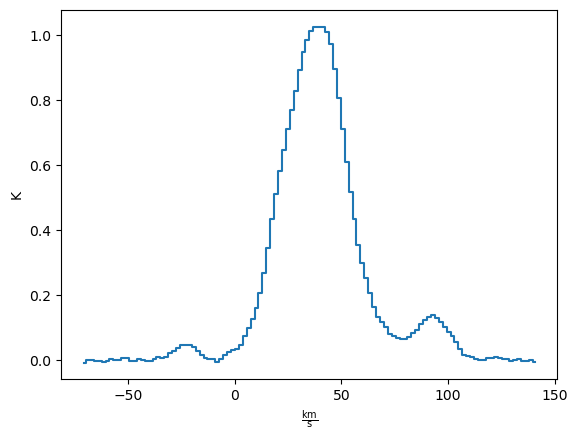

In [219]:
# Assign the file paths of the NH2 and HNCO FITS files
file_nh2 = './gaussfit_iter_with70beta175_column_gc_itervar_conv25.fits'
file_hnco = './CMZ_3mm_HNCO.fits'

# Open and load the FITS files as HDU (Header/Data Unit) objects
hdu_nh2 = fits.open(file_nh2)[0]  # This contains column density data
hdu_hnco = fits.open(file_hnco)[0]  # This contains spectral data for HNCO

# Define the coordinates of the center of the region (l, b) and the radius (r)
l = 0.8062260
b = -0.1878276
r = 177.407

# Create a circular mask for the NH2 data HDU based on given l, b and r 
hdu_masked = mask_hdu(hdu_nh2, l, b, r)

# Calculate the mass of the region in the masked NH2 data
mass = calculate_mass(hdu_masked)

# Load the HNCO data as a SpectralCube, crop to a circular region based on given l, b and r
cropped_cube = crop_cube_circle(hdu_hnco, l, b, r)

# Spectrally slab the cube to keep only the velocities
cropped_cube = cropped_cube.spectral_slab(-70*au.km/au.s, 140*au.km/au.s)

# Calculate the mean spectrum over the spatial dimensions (i.e., average the flux at each velocity channel)
meanspec = cropped_cube.mean(axis=(1,2))

# Access the velocity axis of the cube (spectral_axis), and create a boolean mask for the velocity range
spectral_axis = cropped_cube.spectral_axis.value
mask = (spectral_axis>0) & (spectral_axis<75)

# Calculate the factor which is the ratio of the sum of the mean spectrum where the mask is True 
# to the total sum of the mean spectrum. 
factor = meanspec[mask].sum()/meanspec.sum()

# Plot the mean spectrum
meanspec.quicklook()

print('factor: %0.2f' %factor)
print('total mass [10^5 Msun]: %0.2f' %mass.value)
print('bubble mass [10^5 Msun]: %0.2f' %(mass.value*factor))